In [1]:
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from entot.data.data import MixtureNormalSampler
from entot.plotting.plots import plot_1D_unbalanced

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-19 15:43:07.067573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
source = MixtureNormalSampler(jax.random.PRNGKey(0), [-2.5, 1.0], 1,  0.2, batch_size=1024)
target = MixtureNormalSampler(jax.random.PRNGKey(1), [-1.0,1.0, 5.0], 1,  0.1, batch_size=1024)

2023-09-19 15:43:38.228334: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
epsilon = 5e-2
tau_a = 0.98
tau_b = 0.98

In [4]:
neural_net = MLP_vector_field(1, latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(1, 1)

mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)

ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=epsilon, mlp_eta=mlp_eta, mlp_xi=mlp_xi, tau_a=tau_a, tau_b=tau_b, input_dim=1, output_dim=1, iterations=10_000, k_noise_per_x=1)

In [5]:
otfm(source, target)

100%|██████████| 10000/10000 [03:51<00:00, 43.25it/s]


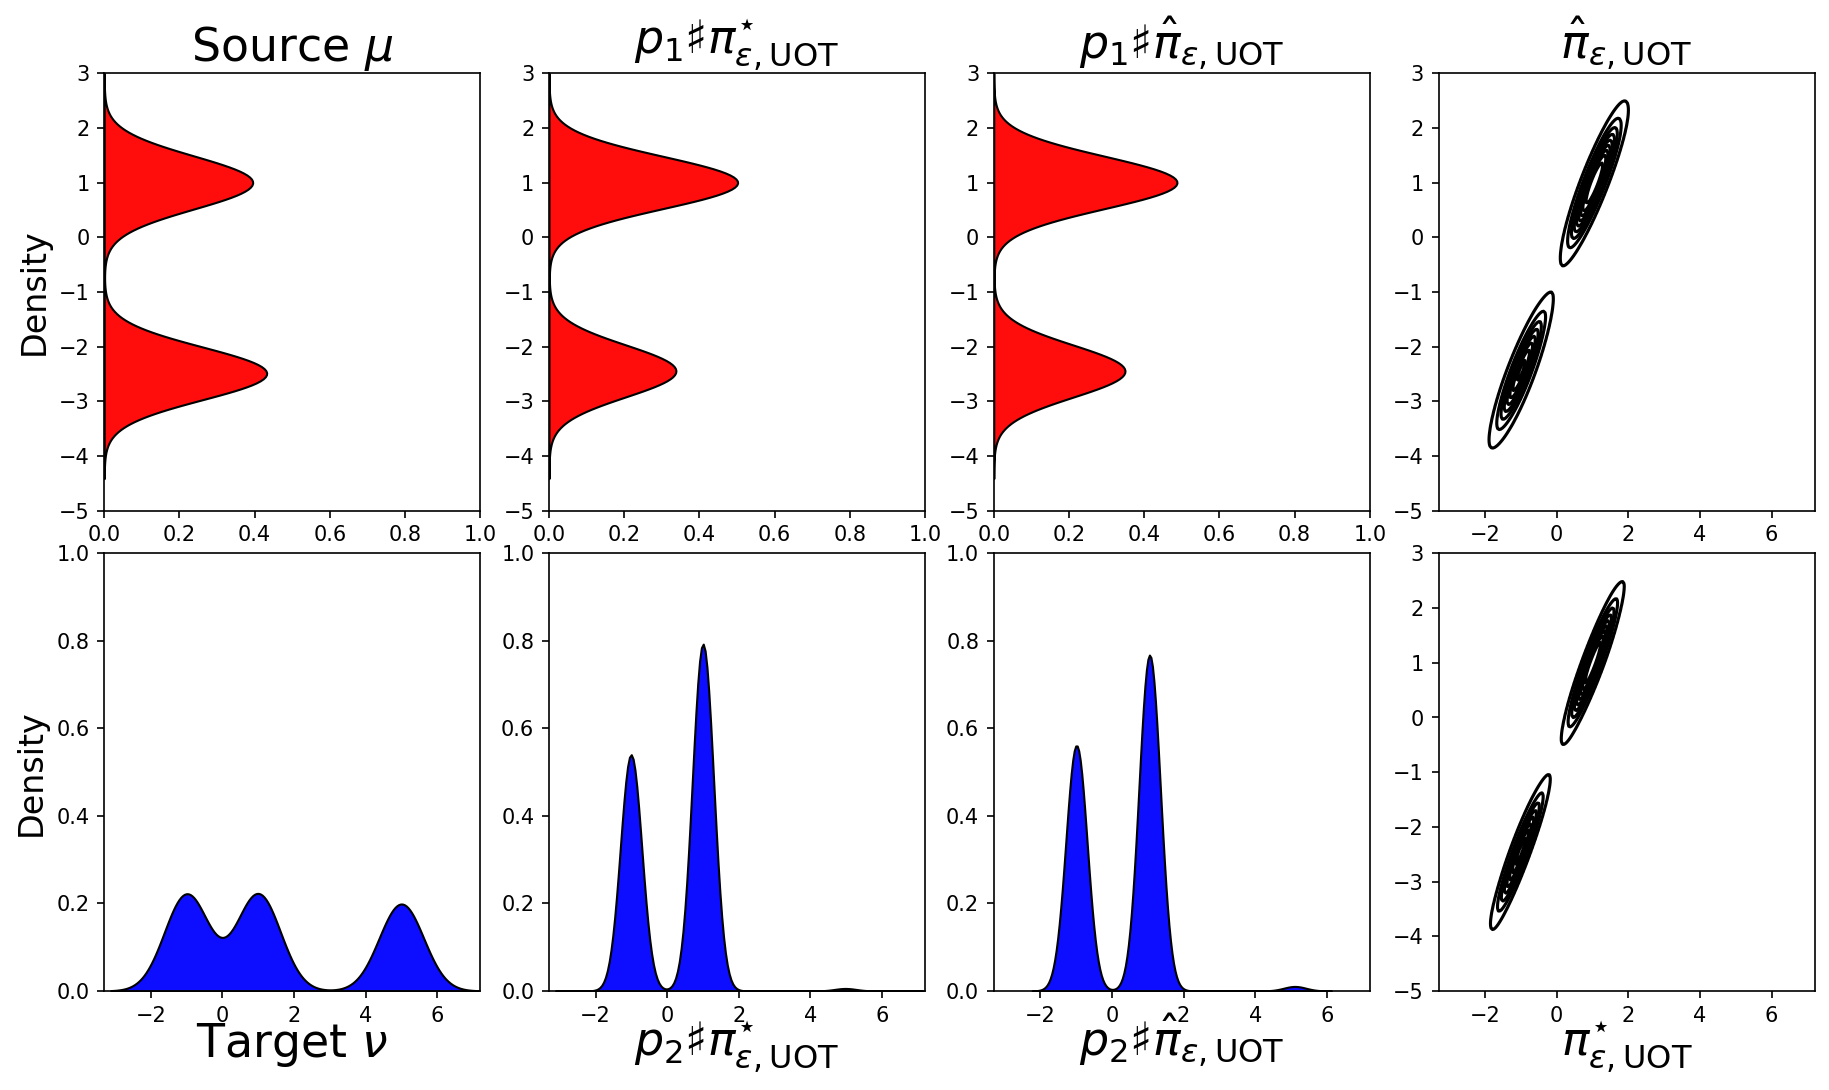

In [6]:
kwargs = {}
a = (-5.0, 3.0) # source support
b = (0.0, 1.0) # density plot
c = (0.0, 4.0)
d = (-3.3, 7.2) # target support
kwargs["00_xlim"] = b
kwargs["01_xlim"] = b
kwargs["02_xlim"] = b
kwargs["03_xlim"] = d
kwargs["10_xlim"] = d
kwargs["11_xlim"] = d
kwargs["12_xlim"] = d
kwargs["13_xlim"] = d

kwargs["00_ylim"] = a
kwargs["01_ylim"] = a
kwargs["02_ylim"] = a
kwargs["03_ylim"] = a
kwargs["10_ylim"] = b
kwargs["11_ylim"] = b
kwargs["12_ylim"] = b
kwargs["13_ylim"] = a

source_batch = next(source)
target_batch = next(target)

rescale_source = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, source_batch)
rescale_target = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, target_batch)

res, _, _ = otfm.transport(source_batch, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})

_  = plot_1D_unbalanced(source_batch, target_batch, res[0,...], rescale_source, rescale_target, epsilon=epsilon, tau_a=tau_a, tau_b=tau_b, seed=1, figsize=(12, 7), dpi=150, **kwargs)